In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

from os import listdir
from os.path import join, isfile, isdir
from glob import glob


In [2]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    optimal_thresholds = []
    sensitivity = []
    specificity = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i] 
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred) # return 
            auc_roc_vals.append(auc_roc)
            fpr, tpr, thresholds = roc_curve(gt, pred)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            y_pred = pred > optimal_threshold
            acc = accuracy_score(gt, y_pred)
            prec = precision_score(gt, y_pred)
            rec = recall_score(gt, y_pred)
            f1_s = f1_score(gt, y_pred)
            accuracy.append(acc)
            precision.append(prec)
            recall.append(rec)
            f1.append(f1_s)
            optimal_thresholds.append(optimal_threshold) # find optimal thresholds https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
            optimal_tpr = round(tpr[optimal_idx],3)
            optimal_1_fpr = round(1 - fpr[optimal_idx],3)
#             print(f"Length of tpr tpr : {len(tpr)} \n Length of thresholds {len(thresholds)}")
#             print(f"optimal index : {optimal_idx} \n Optimal 1 - fpr : {optimal_1_fpr}")
            sensitivity.append(optimal_tpr)
            specificity.append(1-fpr[optimal_idx])
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--') # black dash line
            plt.plot(fpr, tpr,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals, optimal_thresholds, sensitivity, specificity, accuracy, precision, recall, f1



In [3]:
#test_df = pd.read_csv("../input/nih-chest-xray-dataset/test.csv")
#test_df.head()
all_xray_df = pd.read_csv("../input/chestxray8-dataframe/train_df.csv")
all_xray_df.drop(['No Finding'], axis = 1, inplace = True)
all_xray_df.head()

data_dir1 = '../input/data/'
data_dir2 = '../input/chestxray8-dataframe/'
train_df = pd.read_csv(data_dir1 + 'Data_Entry_2017.csv')
image_label_map = pd.read_csv(data_dir2 + 'train_df.csv')
bad_labels = pd.read_csv(data_dir2 + 'cxr14_bad_labels.csv')

# Listing all the .jpg filepaths
image_paths = glob(data_dir1+'images_*/images/*.png')
print(f'Total image files found : {len(image_paths)}')
print(f'Total number of image labels: {image_label_map.shape[0]}')
print(f'Unique patients: {len(train_df["Patient ID"].unique())}')

image_label_map.drop(['No Finding'], axis = 1, inplace = True)
labels = image_label_map.columns[2:-1]
labels

Total image files found : 112120
Total number of image labels: 111863
Unique patients: 30805


Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [4]:
all_xray_df = all_xray_df[89485:] # 22378 images

In [5]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [6]:
train_df.rename(columns={"Image Index": "Index"}, inplace = True)
image_label_map.rename(columns={"Image Index": "Index"}, inplace = True)
train_df = train_df[~train_df.Index.isin(bad_labels.Index)]
train_df.shape

Index =[]
for path in image_paths:
    Index.append(path.split('/')[5])
index_path_map = pd.DataFrame({'Index':Index, 'FilePath': image_paths})
index_path_map.head()

# Merge the absolute path of the images to the main dataframe
pd.merge(train_df, index_path_map, on='Index', how='left')

,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,FilePath
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111858,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
111859,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
111860,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
111861,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


In [7]:
pd.merge(train_df, index_path_map, on='Index', how='left')

,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,FilePath
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111858,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
111859,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
111860,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
111861,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


In [8]:
def get_generator(df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting testing generators...")
    
    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator

In [9]:
print(len(all_xray_df[all_xray_df['Cardiomegaly']==1])
,len(all_xray_df[all_xray_df['Emphysema']==1])
,len(all_xray_df[all_xray_df['Pneumonia']==1])
,len(all_xray_df[all_xray_df['Hernia']==1]))

492 537 243 31


In [10]:
IMAGE_DIR = ""
test_generator= get_generator(all_xray_df, "", "FilePath", labels)


getting testing generators...
Found 22378 validated image filenames.


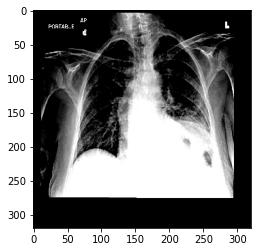

In [11]:
# peek into one item of the test generator
x, y = test_generator.__getitem__(0)
plt.imshow(x[0])

In [ ]:
# ==============================================================================
#  MODEL ARCHITECTURE: SemaCheX-Former
# ==============================================================================

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim), nn.Dropout(dropout)
        )
    def forward(self, x):
        normed_x = self.norm1(x)
        x = x + self.attn(normed_x, normed_x, normed_x)[0]
        x = x + self.mlp(self.norm2(x))
        return x

class PartitionReconstructionAttentionBlock_LMSA(nn.Module):
    def __init__(self, in_channels, dim, patch_size, num_heads, mlp_dim, num_classes, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        patch_dim = in_channels * (patch_size ** 2)
        self.partition = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        self.patch_projection = nn.Linear(patch_dim, dim)
        self.label_embeddings = nn.Parameter(torch.randn(1, num_classes, dim))
        self.attention_module = TransformerEncoderBlock(dim, num_heads, mlp_dim, dropout)
    def forward(self, x):
        b, _, h, w = x.shape
        tokens = self.partition(x)
        label_embs = self.label_embeddings.expand(b, -1, -1)
        tokens = self.patch_projection(tokens)
        processed_tokens = self.attention_module(torch.cat((tokens, label_embs), dim=1))
        processed_visual_tokens = processed_tokens[:, :tokens.shape[1]]
        recon_h, recon_w = h // self.patch_size, w // self.patch_size
        return rearrange(processed_visual_tokens, 'b (h w) d -> b d h w', h=recon_h, w=recon_w)

class ConvSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, reduction=8):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // reduction, 1, bias=False), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // reduction, out_channels, 1, bias=False), nn.Sigmoid()
        )
    def forward(self, x):
        cnn_out = self.conv_block(x)
        return cnn_out * self.se(cnn_out)

class SemaCheXFormer(nn.Module):
    def __init__(self, num_classes=1, dim=256, num_heads=8, mlp_dim=512, cnn_channels=256):
        super().__init__()
        pretrained_model = models.densenet121(weights='IMAGENET1K_V1')
        self.backbone = pretrained_model.features
        backbone_out_channels = 1024
        self.attention_stage = PartitionReconstructionAttentionBlock_LMSA(
            backbone_out_channels, dim, 1, num_heads, mlp_dim, num_classes=1
        )
        self.cnn_se_stage = ConvSEBlock(dim, cnn_channels)
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(cnn_channels, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x)
        attention_out = self.attention_stage(features)
        cnn_out = self.cnn_se_stage(attention_out)
        return self.classification_head(cnn_out)




In [12]:
# create the base pre-trained model
base_model = DenseNet121(weights='../input/chestxray8-dataframe/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# ==============================================================================
# MODEL ARCHITECTURE: SemaCheX-Former
# ==============================================================================

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim), nn.Dropout(dropout)
        )
    def forward(self, x):
        normed_x = self.norm1(x)
        x = x + self.attn(normed_x, normed_x, normed_x)[0]
        x = x + self.mlp(self.norm2(x))
        return x

class PartitionReconstructionAttentionBlock_LMSA(nn.Module):
    def __init__(self, in_channels, dim, patch_size, num_heads, mlp_dim, num_classes, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        patch_dim = in_channels * (patch_size ** 2)
        self.partition = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        self.patch_projection = nn.Linear(patch_dim, dim)
        self.label_embeddings = nn.Parameter(torch.randn(1, num_classes, dim))
        self.attention_module = TransformerEncoderBlock(dim, num_heads, mlp_dim, dropout)
    def forward(self, x):
        b, _, h, w = x.shape
        tokens = self.partition(x)
        label_embs = self.label_embeddings.expand(b, -1, -1)
        tokens = self.patch_projection(tokens)
        processed_tokens = self.attention_module(torch.cat((tokens, label_embs), dim=1))
        processed_visual_tokens = processed_tokens[:, :tokens.shape[1]]
        recon_h, recon_w = h // self.patch_size, w // self.patch_size
        return rearrange(processed_visual_tokens, 'b (h w) d -> b d h w', h=recon_h, w=recon_w)

class ConvSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, reduction=8):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // reduction, 1, bias=False), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // reduction, out_channels, 1, bias=False), nn.Sigmoid()
        )
    def forward(self, x):
        cnn_out = self.conv_block(x)
        return cnn_out * self.se(cnn_out)

class SemaCheXFormer(nn.Module):
    def __init__(self, num_classes=1, dim=256, num_heads=8, mlp_dim=512, cnn_channels=256):
        super().__init__()
        pretrained_model = models.densenet121(weights='IMAGENET1K_V1')
        self.backbone = pretrained_model.features
        backbone_out_channels = 1024
        self.attention_stage = PartitionReconstructionAttentionBlock_LMSA(
            backbone_out_channels, dim, 1, num_heads, mlp_dim, num_classes=1
        )
        self.cnn_se_stage = ConvSEBlock(dim, cnn_channels)
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(cnn_channels, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x)
        attention_out = self.attention_stage(features)
        cnn_out = self.cnn_se_stage(attention_out)
        return self.classification_head(cnn_out)

In [13]:
model.load_weights("../input/chestxray8-dataframe/pretrained_model.h5")

In [14]:
predicted_vals = model.predict(test_generator, steps = len(test_generator), verbose = 1)
# 22378 images with batch size of 8

2798/2798 [==============================] - 560s 197ms/step


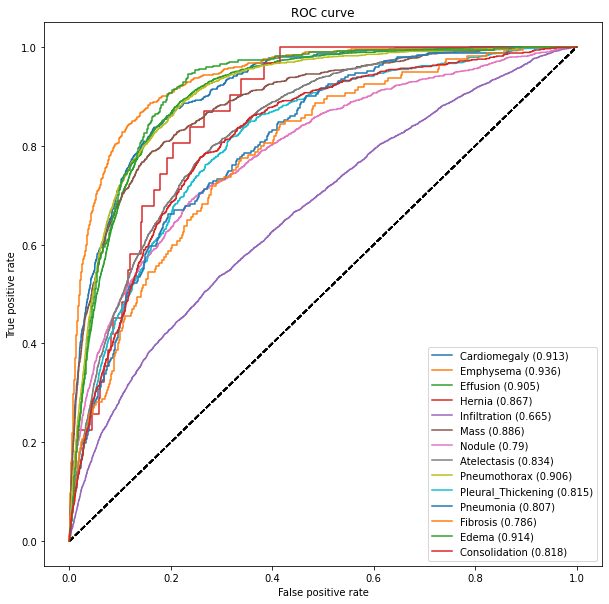

In [15]:
# get roc curve
from statistics import mean
auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1 = get_roc_curve(labels, predicted_vals, test_generator)


In [16]:
# get table of auc_rocs
from tabulate import tabulate
table = zip(labels, auc_rocs)
print(f"Mean AUC : {mean(auc_rocs)}")
print(tabulate(table, headers = ['Pathology', 'AUC'], tablefmt = 'fancy_grid'))

Mean AUC : 0.8458567669362789
╒════════════════════╤══════════╕
│ Pathology          │      AUC │
╞════════════════════╪══════════╡
│ Cardiomegaly       │ 0.912609 │
├────────────────────┼──────────┤
│ Emphysema          │ 0.936044 │
├────────────────────┼──────────┤
│ Effusion           │ 0.904604 │
├────────────────────┼──────────┤
│ Hernia             │ 0.867492 │
├────────────────────┼──────────┤
│ Infiltration       │ 0.665459 │
├────────────────────┼──────────┤
│ Mass               │ 0.886117 │
├────────────────────┼──────────┤
│ Nodule             │ 0.789923 │
├────────────────────┼──────────┤
│ Atelectasis        │ 0.833814 │
├────────────────────┼──────────┤
│ Pneumothorax       │ 0.906098 │
├────────────────────┼──────────┤
│ Pleural_Thickening │ 0.814794 │
├────────────────────┼──────────┤
│ Pneumonia          │ 0.806693 │
├────────────────────┼──────────┤
│ Fibrosis           │ 0.786121 │
├────────────────────┼──────────┤
│ Edema              │ 0.914408 │
├─────────────────

In [17]:
from tabulate import tabulate
table = zip(labels, auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1)
print(tabulate(table, headers = ['Pathology', 'AUC', 'Threshold Value', 'Sensitivity', 'Specificity', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], tablefmt = 'fancy_grid'))

╒════════════════════╤══════════╤═══════════════════╤═══════════════╤═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Pathology          │      AUC │   Threshold Value │   Sensitivity │   Specificity │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════════════╪══════════╪═══════════════════╪═══════════════╪═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Cardiomegaly       │ 0.912609 │          0.519135 │         0.837 │      0.83309  │   0.83314  │   0.101132  │ 0.835366 │ 0.180421   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Emphysema          │ 0.936044 │          0.540763 │         0.851 │      0.877387 │   0.876709 │   0.145501  │ 0.849162 │ 0.248434   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Effusion           │ 0.904604 │        

In [18]:
print(predicted_vals[0:100])


[[0.8589221  0.06059477 0.87367743 ... 0.40323365 0.5229127  0.8438336 ]
 [0.4896218  0.14417109 0.5088553  ... 0.3887865  0.46614608 0.69172823]
 [0.47063744 0.25463772 0.3155718  ... 0.74249434 0.08958298 0.5375239 ]
 ...
 [0.00800658 0.09221837 0.05354214 ... 0.24947467 0.03976247 0.14118883]
 [0.03766359 0.03440103 0.02658275 ... 0.17298344 0.01864811 0.11089148]
 [0.00381578 0.14947836 0.01652813 ... 0.28028923 0.0086062  0.10220635]]


In [19]:
predicted_ls = list(predicted_vals[0:100][6])
labels[predicted_ls.index(max(predicted_ls))]


'Emphysema'

In [20]:

#print([predicted_vals[0:100] > thresholds])

In [21]:
from tensorflow.keras.applications.densenet import preprocess_input
def preprocess_image(img_path, img_size=(320, 320)):
    img = cv2.imread(img_path)  # Read the image
    img = cv2.resize(img, img_size)  # Resize to 320x320
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Normalize the image
    return img

# Predict the class of a single image
def predict_image(img_path, model, labels):
    img = preprocess_image(img_path)
    preds = model.predict(img)  # Get predictions
    # pred_labels = {labels[i]: preds[0][i] for i in range(len(labels))}  # Map to labels
    return preds


# Example usage:
image_path = "/kaggle/input/data/images_004/images/00006585_007.png"  # Replace with actual image path
prediction = list(predict_image(image_path, model, labels))
print(labels[prediction.index(max(prediction))])

Cardiomegaly


In [22]:
# # config = model.get_config()
# # for layer_config in config['layers']:
# #     print(layer_config)

# # class_dict={}
# for layer in config['layers']:
#     if(layer['class_name']=='Conv2D'):
#         layer['config']['name']='conv1'
# for layer_config in config['layers']:
#     print(layer_config)
# #model.save("chest_xray_model.h5")

In [23]:
# config = model.get_config()
# for layer_config in config['layers']:
#     print(layer_config)

In [24]:
model.save("Sema-ChestX-Former.h5",include_optimizer=True)

In [25]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/kaggle/working/chest_xray_model.h5",compile=False)

In [26]:
from tensorflow.keras.applications.densenet import preprocess_input
def preprocess_image(img_path, img_size=(320, 320)):
    img = cv2.imread(img_path)  # Read image
    img = cv2.resize(img, img_size)  # Resize to 320x320
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Normalize
    return img

def predict_image(img_path, model):
    img = preprocess_image(img_path)
    preds = model.predict(img)
    return preds

# Example usage
image_path = "/kaggle/input/data/images_004/images/00006585_007.png"  # Replace with actual image path
prediction = list(predict_image(image_path, loaded_model))
print(labels[prediction.index(max(prediction))])

Cardiomegaly
